# Colab Setup

In [1]:
!nvidia-smi

Tue Oct  1 14:00:08 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    38W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


# Imports and Data Setup

In [3]:
!wget https://archive.org/download/wpdx_imgs/wpdx_imgs.zip

--2019-10-01 14:00:23--  https://archive.org/download/wpdx_imgs/wpdx_imgs.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia801507.us.archive.org/34/items/wpdx_imgs/wpdx_imgs.zip [following]
--2019-10-01 14:00:23--  https://ia801507.us.archive.org/34/items/wpdx_imgs/wpdx_imgs.zip
Resolving ia801507.us.archive.org (ia801507.us.archive.org)... 207.241.228.157
Connecting to ia801507.us.archive.org (ia801507.us.archive.org)|207.241.228.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 728752974 (695M) [application/zip]
Saving to: ‘wpdx_imgs.zip’

wpdx_imgs.zip       100%[===================>] 694.99M  6.87MB/s    in 7m 18s  

2019-10-01 14:07:42 (1.59 MB/s) - ‘wpdx_imgs.zip’ saved [728752974/728752974]



In [0]:
!unzip -qq ./wpdx_imgs.zip -d ./data/

In [0]:
!mv ./data/test/ ./data/valid/

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.tracker import SaveModelCallback

In [0]:
datapath = Path('./data')

## Verify and load images

In [0]:
verify_images(datapath, recurse=True)

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(datapath,
                                  ds_tfms=get_transforms(), 
                                  size=224,
                                  num_workers=4).normalize(imagenet_stats)

In [11]:
data.classes

['Borehole - Mechanized',
 'Borehole - Mechanized with diesel',
 'Bucket',
 'Hand Pump',
 'Hand Pump - Afridev',
 'Hand Pump - India Mark II',
 'Hand Pump - Vergnet',
 'Kiosk',
 'Other',
 'Protected Spring',
 'Tapstand']

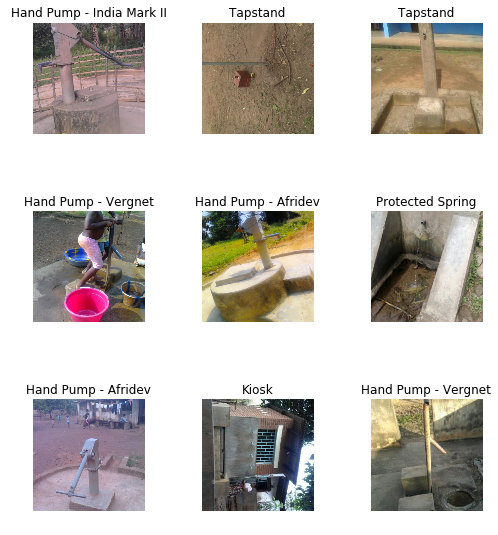

In [12]:
data.show_batch(rows=3, figsize=(7,8))

In [13]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Borehole - Mechanized',
  'Borehole - Mechanized with diesel',
  'Bucket',
  'Hand Pump',
  'Hand Pump - Afridev',
  'Hand Pump - India Mark II',
  'Hand Pump - Vergnet',
  'Kiosk',
  'Other',
  'Protected Spring',
  'Tapstand'],
 11,
 5938,
 1484)

# Train model

In [14]:
learn = cnn_learner(data, models.densenet121, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 89.1MB/s]


In [15]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [128, 56, 56]        8,192      False     
___________________________________________________

In [16]:
learn.fit_one_cycle(10, 
                    callbacks=[SaveModelCallback(learn, 
                                                 every='improvement', 
                                                 monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,1.794940,0.960639,0.710243,02:28
1,1.138727,0.798541,0.742588,02:19
2,0.859543,0.644632,0.804582,02:18
3,0.684460,0.605948,0.813342,02:20
4,0.560743,0.551920,0.824124,02:18
5,0.457353,0.554795,0.832210,02:18
6,0.387609,0.520410,0.838275,02:17
7,0.322451,0.524413,0.840297,02:18
8,0.297594,0.511561,0.845687,02:19
9,0.250810,0.507841,0.849057,02:19


Better model found at epoch 0 with accuracy value: 0.7102425694465637.
Better model found at epoch 1 with accuracy value: 0.7425876259803772.
Better model found at epoch 2 with accuracy value: 0.8045822381973267.
Better model found at epoch 3 with accuracy value: 0.8133423328399658.
Better model found at epoch 4 with accuracy value: 0.8241239786148071.
Better model found at epoch 5 with accuracy value: 0.8322102427482605.
Better model found at epoch 6 with accuracy value: 0.8382749557495117.
Better model found at epoch 7 with accuracy value: 0.8402965068817139.
Better model found at epoch 8 with accuracy value: 0.8456873297691345.
Better model found at epoch 9 with accuracy value: 0.849056601524353.


In [0]:
learn.save('stage-1')

# Finetune model

In [0]:
learn.unfreeze()

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


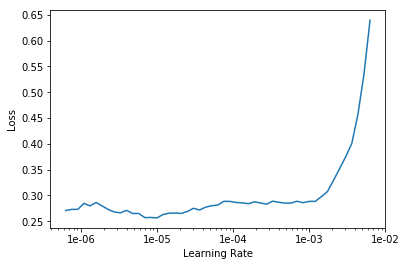

In [20]:
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(10, 
                    max_lr=slice(8e-5, 3e-5),
                    callbacks=[SaveModelCallback(learn, 
                                                 every='improvement', 
                                                 monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,0.255459,0.508858,0.847709,02:35
1,0.250708,0.523790,0.842992,02:35
2,0.236755,0.510517,0.845013,02:36
3,0.207847,0.494489,0.853100,02:36
4,0.183707,0.495925,0.854447,02:35
5,0.164742,0.490575,0.855121,02:34
6,0.141272,0.491252,0.861186,02:35
7,0.124819,0.487156,0.857817,02:35
8,0.114758,0.487557,0.862534,02:35
9,0.108519,0.490256,0.862534,02:35


Better model found at epoch 0 with accuracy value: 0.8477088809013367.
Better model found at epoch 3 with accuracy value: 0.8530997037887573.
Better model found at epoch 4 with accuracy value: 0.8544474244117737.
Better model found at epoch 5 with accuracy value: 0.8551213145256042.
Better model found at epoch 6 with accuracy value: 0.8611859679222107.
Better model found at epoch 8 with accuracy value: 0.862533688545227.


In [0]:
learn.save('stage-2')

# Validate Model

In [25]:
learn.validate()

[0.48755687, tensor(0.8625)]

In [0]:
interpret = ClassificationInterpretation.from_learner(learn)

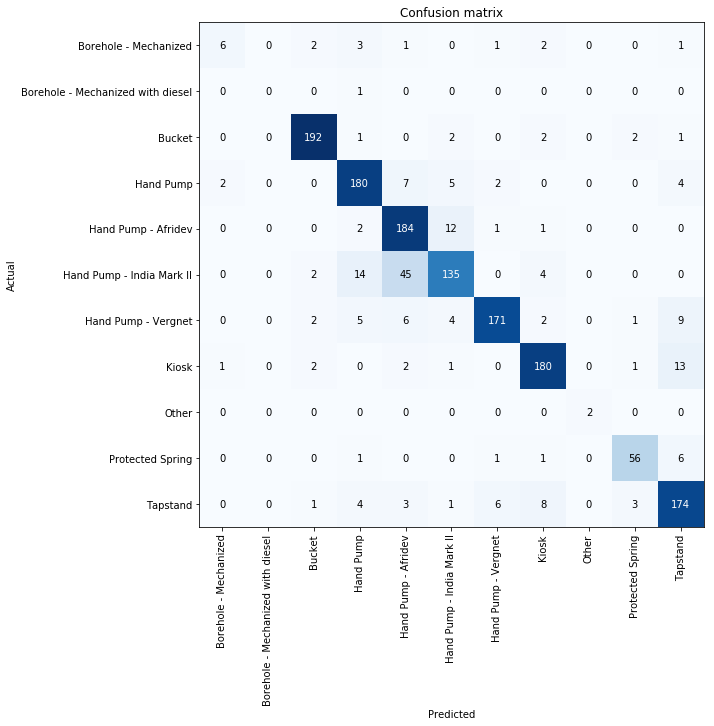

In [27]:
interpret.plot_confusion_matrix(figsize=(10,10))

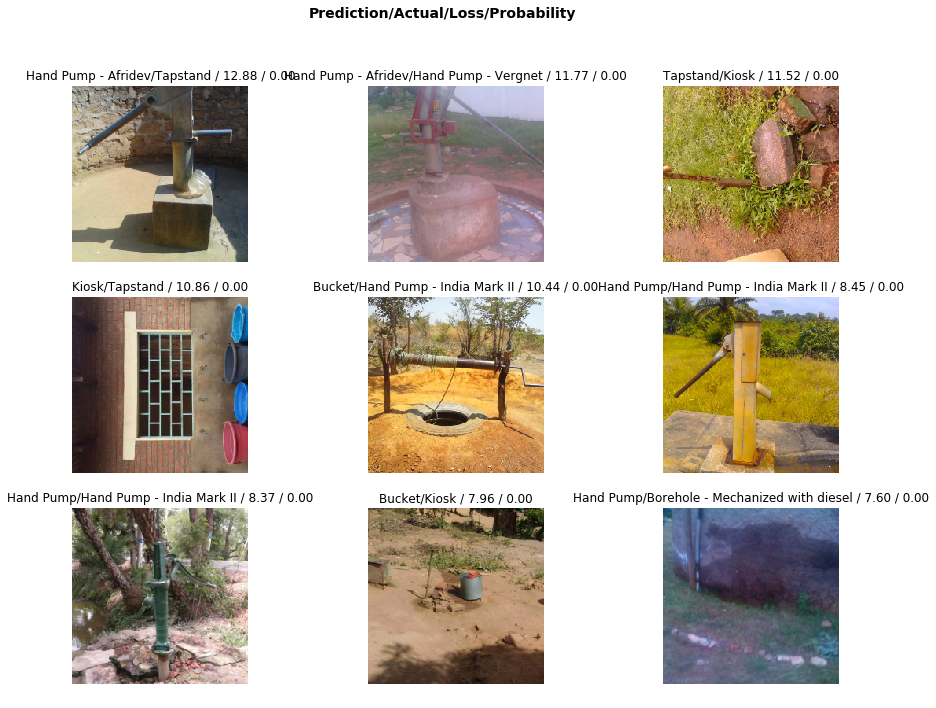

In [28]:
interpret.plot_top_losses(9, figsize=(15,11))

# Export model

## fastai learner export

In [0]:
learn.export('wpdx_model_export.pkl')

## ONNX export

In [0]:
import torch
import torch.onnx

In [31]:
dummy_input = torch.autograd.Variable(torch.rand(1,3,224,224, device='cuda'))
torch.onnx.export(learn.model, dummy_input, "wpdx_model.onnx", verbose=True)

graph(%input.1 : Float(1, 3, 224, 224),
      %0.0.conv0.weight : Float(64, 3, 7, 7),
      %0.0.norm0.weight : Float(64),
      %0.0.norm0.bias : Float(64),
      %0.0.norm0.running_mean : Float(64),
      %0.0.norm0.running_var : Float(64),
      %0.0.norm0.num_batches_tracked : Long(),
      %0.0.denseblock1.denselayer1.norm1.weight : Float(64),
      %0.0.denseblock1.denselayer1.norm1.bias : Float(64),
      %0.0.denseblock1.denselayer1.norm1.running_mean : Float(64),
      %0.0.denseblock1.denselayer1.norm1.running_var : Float(64),
      %0.0.denseblock1.denselayer1.norm1.num_batches_tracked : Long(),
      %0.0.denseblock1.denselayer1.conv1.weight : Float(128, 64, 1, 1),
      %0.0.denseblock1.denselayer1.norm2.weight : Float(128),
      %0.0.denseblock1.denselayer1.norm2.bias : Float(128),
      %0.0.denseblock1.denselayer1.norm2.running_mean : Float(128),
      %0.0.denseblock1.denselayer1.norm2.running_var : Float(128),
      %0.0.denseblock1.denselayer1.norm2.num_batches_trac

# load_learner model demo

In [0]:
learnGo = load_learner('./data/','wpdx_model_export.pkl')

In [33]:
img = open_image('./data/valid/Tapstand/00000005.jpg')
data.classes[int(learnGo.predict(img)[1])]

'Tapstand'

# Validate ONNX model

In [34]:
!pip install onnx

     |████████████████████████████████| 4.8MB 6.6MB/s 


In [0]:
import onnx
wpdx_model_onnx = onnx.load('./wpdx_model.onnx')

In [0]:
onnx.checker.check_model(wpdx_model_onnx)

In [4]:
print(onnx.helper.printable_graph(wpdx_model_onnx.graph))

graph torch-jit-export (
  %input.1[FLOAT, 1x3x224x224]
) optional inputs with matching initializers (
  %0.0.conv0.weight[FLOAT, 64x3x7x7]
  %0.0.norm0.weight[FLOAT, 64]
  %0.0.norm0.bias[FLOAT, 64]
  %0.0.norm0.running_mean[FLOAT, 64]
  %0.0.norm0.running_var[FLOAT, 64]
  %0.0.norm0.num_batches_tracked[INT64, scalar]
  %0.0.denseblock1.denselayer1.norm1.weight[FLOAT, 64]
  %0.0.denseblock1.denselayer1.norm1.bias[FLOAT, 64]
  %0.0.denseblock1.denselayer1.norm1.running_mean[FLOAT, 64]
  %0.0.denseblock1.denselayer1.norm1.running_var[FLOAT, 64]
  %0.0.denseblock1.denselayer1.norm1.num_batches_tracked[INT64, scalar]
  %0.0.denseblock1.denselayer1.conv1.weight[FLOAT, 128x64x1x1]
  %0.0.denseblock1.denselayer1.norm2.weight[FLOAT, 128]
  %0.0.denseblock1.denselayer1.norm2.bias[FLOAT, 128]
  %0.0.denseblock1.denselayer1.norm2.running_mean[FLOAT, 128]
  %0.0.denseblock1.denselayer1.norm2.running_var[FLOAT, 128]
  %0.0.denseblock1.denselayer1.norm2.num_batches_tracked[INT64, scalar]
  %0.0.den